## ABC Estimation - Approximate Bayesian Computation

In [1]:
import ast
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from broadcastplatform import Platform
import time
import itertools

In [2]:
generic = lambda x:ast.literal_eval(x)
conv = {'StartOpinion': generic,
             'Density': generic,
          'AveOpinion':generic,
              'AveStd':generic,
            'PosRatio':generic,
     'ExpressionRatio':generic}

In [3]:
samples = pd.read_csv('SampleRecord.txt',converters=conv)
sample_0 = samples.loc[0]
sample_0

RoomID                                                        485503
Time1                                                     2018-10-21
Time2                                                           21:3
Population                                                       848
StartOpinion       [0.6980678229578181, 0.15185191051103036, -0.3...
Density            {1: 464, 2: 183, 3: 67, 4: 47, 5: 23, 6: 11, 7...
AveOpinion         [0.29385934591975094, 0.44557168991311513, 0.3...
AveStd             [0.5286719173096472, 0.33604725030305344, 0.71...
PosRatio           [0.75, 0.8, 0.8333333333333334, 0.5, 0.25, 0.6...
ExpressionRatio    [0.0047169811320754715, 0.00589622641509434, 0...
Name: 0, dtype: object

In [4]:
count_dict = sample_0['Density']
count_array = []
for k in count_dict:
    count_array += (count_dict[k]*[k])
density_array = np.array(count_array)*2/len(sample_0['AveOpinion'])

In [5]:
unique_density = np.unique(density_array)
unique_density

array([0.00333333, 0.00666667, 0.01      , 0.01333333, 0.01666667,
       0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667, 0.05333333,
       0.05666667, 0.10666667, 0.11      , 0.12666667])

In [6]:
bin_edges_1 = np.append(unique_density[:14], [unique_density[13]+unique_density[0],unique_density[15]+unique_density[0],
                                              unique_density[18]+unique_density[0]])
bin_edges_1

array([0.00333333, 0.00666667, 0.01      , 0.01333333, 0.01666667,
       0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667, 0.05      ,
       0.06      , 0.13      ])

In [7]:
bin_edges_2 = np.append(unique_density[:14], [unique_density[13]+unique_density[0],unique_density[15]+unique_density[0]])
bin_edges_2

array([0.00333333, 0.00666667, 0.01      , 0.01333333, 0.01666667,
       0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667, 0.05      ,
       0.06      ])

In [8]:
bin_edges_3 = np.append(unique_density[:14], [unique_density[13]+unique_density[0]])
bin_edges_3

array([0.00333333, 0.00666667, 0.01      , 0.01333333, 0.01666667,
       0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667, 0.05      ])

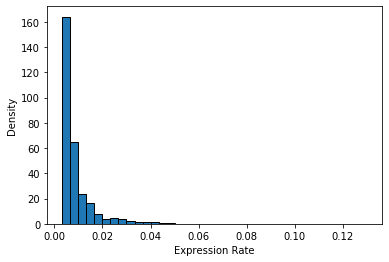

In [9]:
density_count, density_bins, density_ignored = plt.hist(density_array, bins = bin_edges_1,
                                                        density=True, edgecolor='k')
plt.xlabel('Expression Rate')
plt.ylabel('Density')
plt.show()

In [7]:
# Using MLE to estimate
def NLL(paras, dist, xvals):
    '''
    --------------------------------------------------------------------
    Calculate the negative log-likelihood value from the data with 
    the assumed distribution
    --------------------------------------------------------------------
    INPUTS:
    paras = (N,) vector, values of parameters 
    xvals = (N,) vector, values of the random variable
    dist  = function (callable), name for the distribution 
            (should have the member logpdf(x, ...))   
    
    RETURNS: negative log-likelihood value
    --------------------------------------------------------------------
    '''
    nll = sum(dist.logpdf(xvals, *paras, loc=min(xvals)*(1-0.30)))*(-1) 
    return nll 

# calculate the GA MLE to estimate the parameter for entertainment parameters
density_mean = np.mean(density_array)
density_var = np.var(density_array)
alpha_init = (((1-density_mean)/density_var)-(1/density_mean))*(density_mean**2)
beta_init = alpha_init*((1/density_mean)-1)
Beta_MLE_result_1 = sp.optimize.minimize(NLL, np.array((alpha_init, beta_init)), 
                                   args = (sp.stats.beta, density_array), 
                                   tol=1e-50, method="SLSQP", options={'maxiter': 1000}, 
                                   bounds=[(1e-10,None),(1e-10,None)])
print(Beta_MLE_result_1) 

     fun: -3593.9850808275582
     jac: array([0.00296021, 0.00531006])
 message: 'Optimization terminated successfully.'
    nfev: 149
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([  0.78114435, 143.250829  ])


In [11]:
# calculate the GA MLE to estimate the parameter for entertainment parameters
density_mean = np.mean(density_array[:-3])
density_var = np.var(density_array[:-3])
alpha_init = (((1-density_mean)/density_var)-(1/density_mean))*(density_mean**2)
beta_init = alpha_init*((1/density_mean)-1)
Beta_MLE_result_2 = sp.optimize.minimize(NLL, np.array((alpha_init, beta_init)), 
                                   args = (sp.stats.beta, density_array[:-3]), 
                                   tol=1e-50, method="SLSQP", options={'maxiter': 1000}, 
                                   bounds=[(1e-10,None),(1e-10,None)])
print(Beta_MLE_result_2) 

     fun: -3635.6697079098753
     jac: array([0.00314331, 0.00320435])
 message: 'Optimization terminated successfully.'
    nfev: 144
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([  0.84290592, 166.81428907])


In [12]:
NLL(Beta_MLE_result_2.x, sts.beta, density_array)

-3590.127684189683

In [13]:
# Using GMM to estimate
def GMM_model_moments(alpha, beta, bin_edges): 
    return sp.stats.beta.cdf(bin_edges[1:], alpha, beta, loc=min(bin_edges)*(1-0.30))-\
           sp.stats.beta.cdf(bin_edges[:-1], alpha, beta, loc=min(bin_edges)*(1-0.30))

# define error function
def GMM_err_vec(data_moments, alpha, beta, bin_edges, simple):
    model_moments = GMM_model_moments(alpha, beta, bin_edges)
    if simple:
        return  model_moments - data_moments
    else:
        return (model_moments - data_moments) / data_moments
    
# define criterion function
def GMM_criterion(paras, *args):
    alpha, beta = paras
    data_moments, bin_edges, simple, W = args
    error_vec = GMM_err_vec(data_moments, alpha, beta, bin_edges, simple)
    return error_vec.T @ W @ error_vec
            
density_data_moments_1 = np.histogram(density_array, 
bins = bin_edges_1, weights=[1/len(density_array)]*len(density_array))[0]
                                    
W_fixed_1 = np.diag(density_data_moments_1)
density_mean = np.mean(density_array)
density_var = np.var(density_array)
alpha_init = (((1-density_mean)/density_var)-(1/density_mean))*(density_mean**2)
beta_init = alpha_init*((1/density_mean)-1)
                                    
Beta_GMM_result_1 = sp.optimize.minimize(GMM_criterion, np.array((alpha_init, beta_init)),
                                args=(density_data_moments_1, bin_edges_1, False, W_fixed_1), 
                                tol = 1e-50, method="SLSQP", options={'maxiter': 1000}, 
                                bounds=[(1e-10, None), (1e-10, None)])
Beta_GMM_result_1

     fun: 0.08321708396935486
     jac: array([2.92249024e-06, 3.16277146e-06])
 message: 'Optimization terminated successfully.'
    nfev: 297
     nit: 45
    njev: 45
  status: 0
 success: True
       x: array([  1.10345289, 243.09299208])

In [14]:
NLL(Beta_GMM_result_1.x, sts.beta, density_array)

-3539.3131523978636

In [15]:
density_data_moments_2 = np.histogram(density_array, 
bins = bin_edges_2, weights=[1/len(density_array)]*len(density_array))[0]
                                    
W_fixed_2 = np.diag(density_data_moments_2)
density_mean = np.mean(density_array)
density_var = np.var(density_array)
alpha_init = (((1-density_mean)/density_var)-(1/density_mean))*(density_mean**2)
beta_init = alpha_init*((1/density_mean)-1)
                                    
Beta_GMM_result_2 = sp.optimize.minimize(GMM_criterion, np.array((alpha_init, beta_init)),
                                args=(density_data_moments_2, bin_edges_2, False, W_fixed_2), 
                                tol = 1e-50, method="SLSQP", options={'maxiter': 1000}, 
                                bounds=[(1e-10, None), (1e-10, None)])
Beta_GMM_result_2

     fun: 0.07968083420321395
     jac: array([-9.45292413e-07,  1.11665577e-06])
 message: 'Optimization terminated successfully.'
    nfev: 198
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([  1.10360434, 243.137962  ])

In [16]:
NLL(Beta_GMM_result_2.x, sts.beta, density_array)

-3539.270231443192

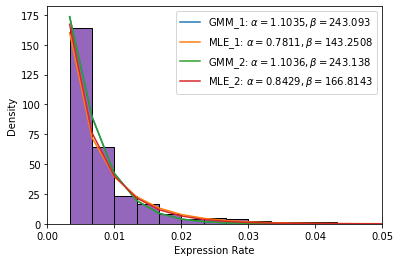

In [17]:
plt.plot(bin_edges_1, 
         sp.stats.beta.pdf(bin_edges_1, Beta_GMM_result_1.x[0], Beta_GMM_result_1.x[1],loc=min(bin_edges_1)*(1-0.30)),
         linewidth=1.5, 
         label=r'GMM_1: $\alpha={}, \beta={}$'.format(round(Beta_GMM_result_1.x[0],4),
                                                    round(Beta_GMM_result_1.x[1],4)))
plt.plot(bin_edges_1, 
         sp.stats.beta.pdf(bin_edges_1, a=Beta_MLE_result_1.x[0], b=Beta_MLE_result_1.x[1], loc=min(bin_edges_1)*(1-0.30)),
         linewidth=1.5, 
         label=r'MLE_1: $\alpha={}, \beta={}$'.format(round(Beta_MLE_result_1.x[0],4),
                                                    round(Beta_MLE_result_1.x[1],4)))
plt.plot(bin_edges_2, 
         sp.stats.beta.pdf(bin_edges_2, Beta_GMM_result_2.x[0], Beta_GMM_result_2.x[1],loc=min(bin_edges_2)*(1-0.30)),
         linewidth=1.5, 
         label=r'GMM_2: $\alpha={}, \beta={}$'.format(round(Beta_GMM_result_2.x[0],4),
                                                    round(Beta_GMM_result_2.x[1],4)))
plt.plot(bin_edges_2, 
         sp.stats.beta.pdf(bin_edges_2, a=Beta_MLE_result_2.x[0], b=Beta_MLE_result_2.x[1], loc=min(bin_edges_2)*(1-0.30)),
         linewidth=1.5, 
         label=r'MLE_2: $\alpha={}, \beta={}$'.format(round(Beta_MLE_result_2.x[0],4),
                                                    round(Beta_MLE_result_2.x[1],4)))
density_count, density_bins, density_ignored = plt.hist(density_array, bins = bin_edges_1,
                                                        density=True, edgecolor='k')
plt.rcParams['figure.figsize'] = (15,6)
plt.xlim([0,0.05])
plt.xlabel('Expression Rate')
plt.ylabel('Density')
plt.legend()
plt.savefig('estimation pictures/'+'beta estimation')
plt.show()

MLE_1 yields better results for the estimation of beta's parameter, using it as the given parameter values for the following SMM estimation.

In [46]:
np.mean(np.array(sample_0['AveOpinion']).reshape(10,60),axis=1)

array([-0.02442171, -0.10672438, -0.05058903, -0.0041473 , -0.19895596,
       -0.41707381, -0.04224451, -0.25331301,  0.09310206,  0.11354135])

In [47]:
np.var(np.array(sample_0['AveOpinion']).reshape(10,60),axis=1)

array([0.15920555, 0.22494961, 0.1914122 , 0.20795414, 0.20141752,
       0.1644643 , 0.19084625, 0.14604504, 0.1846159 , 0.17493586])

In [50]:
np.mean((np.array(sample_0['AveStd'])**2).reshape(10,60),axis=1)

array([0.37649168, 0.29556217, 0.20973131, 0.2304645 , 0.35920384,
       0.24579874, 0.15716777, 0.31109615, 0.27485226, 0.21133944])

In [51]:
np.mean(np.array(sample_0['PosRatio']).reshape(10,60),axis=1)

array([0.4693254 , 0.38980159, 0.4625    , 0.52555556, 0.37361111,
       0.2522102 , 0.46587963, 0.34131541, 0.51369048, 0.52728175])

In [8]:
# generate identity matrix
W_identity = np.eye(2*10)
W_identity.shape

(20, 20)

In [24]:
%%writefile estimation.py
import ast
import pyabc
import time
import math
import numpy as np
import scipy as sp
import scipy.stats as sts
import os
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import multiprocessing as mp
from broadcastplatform import Platform

class estimation(object):
    
    def __init__(self,W,nr_particles=100,p_mode=1,host_mode='triang',err_mode=0):
        self.W = W
        self.host_mode = host_mode
        self.p_mode = p_mode
        self.err_mode = err_mode
        # building parameter prior distribution
        if self.host_mode == 'triang':
            self.prior=pyabc.Distribution(at=pyabc.RV("uniform", 0, 1),rt=pyabc.RV("uniform", 1, 1),ba=pyabc.RV("uniform", 0, 1),
                                          bm=pyabc.RV("uniform", -1, 2),bl=pyabc.RV("uniform", -1, 2),ps=pyabc.RV("uniform", 0, 1),
                                          pi=pyabc.RV("uniform", 0, 1))
        else:
            self.prior=pyabc.Distribution(at=pyabc.RV("uniform", 0, 1),rt=pyabc.RV("uniform", 1, 1),ba=pyabc.RV("uniform", 0, 1),
                                          bm=pyabc.RV("uniform", -1, 2),bl=pyabc.RV("uniform", 0, 1),ps=pyabc.RV("uniform", 0, 1),
                                          ns=pyabc.RV("uniform", 0, 1),pi=pyabc.RV("uniform", 0, 1))
        self.nr_particles=nr_particles
        self.abc=pyabc.ABCSMC(self.model, self.prior, distance_function=self.distance, 
                              population_size=pyabc.populationstrategy.ConstantPopulationSize(nr_particles=self.nr_particles),
                              eps=pyabc.epsilon.MedianEpsilon(80))
        
    
    def draw_generation(self,sample,s):
        t = len(sample['AveOpinion'])
        p = int(sample['Population'])
        self.draws = []
        for i in range(s):
            draws_dict = {}
            draws_dict['beta_draw'] = sts.uniform.rvs(0,1,p)
            draws_dict['bernoulli_draw'] = sts.uniform.rvs(0,1,[p,t])
            draws_dict['uniform_draw'] = sts.uniform.rvs(0,1,p)
            draws_dict['host_draw'] = sts.uniform.rvs(0,1,t)
            self.draws.append(draws_dict)      

    def observe(self,index, beta, s=10):
        self.sample_index=index
        self.beta_a, self.beta_b = beta
        generic = lambda x:ast.literal_eval(x)
        conv = {'StartOpinion': generic,
                'Density': generic,
                'AveOpinion':generic,
                'AveStd':generic,
                'PosRatio':generic,
                'ExpressionRatio':generic
               }
        df = pd.read_csv('SampleRecord.txt',header=0,converters=conv)
        self.draw_generation(df.loc[index],s)
        self.initial=[df.iloc[index]['Population'],df.iloc[index]['StartOpinion'],len(df.loc[index]['AveOpinion'])]
        ave_eo = np.array(df.iloc[index]['AveOpinion'])
        var_eo = np.array(df.iloc[index]['AveStd'])**2
        self.realdata={"AveOpinion":np.mean(np.array(ave_eo).reshape(10,60),axis=1),
                       "AveVar":np.mean(np.array(var_eo).reshape(10,60),axis=1)  
                      }
        
        
    def err_vec(self, data, model):
        data_moments = list(data.values())
        model_moments = list(model.values())
        model_moment_array = np.array(list(itertools.chain(*model_moments)))
        data_moment_array = np.array(list(itertools.chain(*data_moments)))
        if self.err_mode == 0:
            err = data_moment_array - model_moment_array
        elif self.err_mode == 1:
            err = (data_moment_array - model_moment_array)/data_moment_array
        return err

        
    #distance function: similar to the criterion function in SMM
    def distance(self, data, model):
        error = self.err_vec(data, model)    
        return error.T @ self.W @ error

    #setting constraints
    def constraints(self,parameters):
        cons = []
        cons.append(1.0-parameters['ps']-parameters['pi'])
        if self.host_mode=='triang':
            cons.append(parameters['bm']-parameters['bl'])
        for c in cons:
            if c < 0:
                return False
        return True
    
    def simulation(self, draw, parameters):
        beta_draw = draw['beta_draw']
        bernoulli_draw = draw['bernoulli_draw']
        uniform_draw = draw['uniform_draw']
        host_draw = draw['host_draw']
        tempbp=Platform(beta_draw, bernoulli_draw, uniform_draw, host_draw,
                        at=parameters['at'],rt=parameters['rt'],ba=parameters['ba'],bm=parameters['bm'],
                        bl=parameters['bl'],ps=parameters['ps'],pi=parameters['pi'],
                        beta_a=self.beta_a, beta_b=self.beta_b, p_mode=self.p_mode, host_mode=self.host_mode,
                        te=self.initial[2],p=self.initial[0])
        tempbp.Evolution(self.initial[1])
        ave_eo, var_eo = tempbp.AveExpressedSeries(show=False)
        return {"AveOpinion":np.mean(np.array(ave_eo).reshape(10,60),axis=1),
                "AveVar":np.mean(np.array(var_eo).reshape(10,60),axis=1)
                #"PosRatioSeries":np.array(tempbp.PosRatioSeries(show=False)),
                #"ExpressionRatioSeries":np.array(tempbp.ExpressionRatioSeries(show=False)),
               }
    
    #simulation model
    def model(self, parameters):
        if self.constraints(parameters)==True:
            rep_paras = [(draw, parameters) for draw in self.draws]
            replication=list(itertools.starmap(self.simulation,rep_paras))
            statistics={"AveOpinion":np.mean([x["AveOpinion"] for x in replication],axis=0),
                        "AveVar":np.mean([x["AveVar"] for x in replication],axis=0),
                       }
        else:
            statistics={"AveOpinion":np.array([3]*10),
                        "AveVar":np.array([3]*10)}
        return statistics

    def estimate(self,path="sqlite:///estimation.db",minimum_epsilon=0.0,max_nr_populations=20):
        if self.realdata==None:
            print("observe the real data!")
        else:
            self.minimum_epsilon = minimum_epsilon
            self.max_nr_populations = max_nr_populations
            self.abc.new(path,self.realdata)
            self.history = self.abc.run(minimum_epsilon=self.minimum_epsilon, max_nr_populations=self.max_nr_populations)
            
    def visualize(self):
        conversion={'at':r'$d_1$','rt':r'$d_2$',
                    'ba':r'$b$','bl':r'$l$','bm':r'$m$',
                    'ps':r'$k_P$','pi':r'$c$'}
        df, w = self.history.get_distribution(m=0)
        self.result={}
        n_paras = len(df.columns)
        fig = plt.figure(figsize=[20,8]) 
        for index in range(n_paras):
            i = df.columns[index]
            weighted_ave = np.average(df[i],weights=w)
            weighted_var = np.average((np.array(df[i])-weighted_ave)**2,weights=w)
            self.result[i]=(weighted_ave, weighted_var**0.5)
            ax = fig.add_subplot(math.ceil(n_paras/4),4,index)
            pyabc.visualization.plot_kde_1d_highlevel(self.history, x=i, ax=ax)
            ax.set_xlabel(conversion[i])
        print(self.result)
        plt.savefig('estimation pictures/'+'SMM-ABC estimation')
        plt.show()
    
    def compare(self):
        if self.result!={}:
            parameters={}
            df=pd.read_csv('CompareResults.txt')
            CompareRow={'sample_index':self.sample_index,'nr_particles':self.nr_particles,
                        'minimum_epsilon': self.minimum_epsilon,'max_nr_populations':self.max_nr_populations}
            for i in self.result.keys():
                parameters[i]=self.result[i][0]
            simulation=self.model(parameters)
            real=self.realdata
            #Statistical-test
            for j in simulation.keys():
                print(j+':')
                print(st.ks_2samp(simulation[j],real[j]))
                CompareRow['ks_2samp']=st.ks_2samp(simulation[j],real[j])
                print(st.pearsonr(simulation[j],real[j]))
                CompareRow['pearsonr']=st.pearsonr(simulation[j],real[j])
                print(st.ttest_rel(simulation[j],real[j])) 
                CompareRow['ttest_rel']=st.ttest_rel(simulation[j],real[j])
            df=df.append(CompareRow,ignore_index=True)
            df.to_csv('CompareResults.txt',mode='w+',index=False)
        else:
            print("need estimation results!")

Overwriting estimation.py


In [ ]:
import importlib
import estimation
importlib.reload(estimation)

if __name__ == "__main__":
    test = estimation.estimation(
        W_identity, nr_particles=100, p_mode=1, host_mode='triang', err_mode=0)
    test.observe(0, Beta_MLE_result_1.x, s=10)
    test.estimate(minimum_epsilon=0.1, max_nr_populations=20)

INFO:Sampler:Parallelizing the sampling on 56 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2020-03-20 15:00:19.302179, end_time=None)>
INFO:ABC:t: 0, eps: 80.
INFO:ABC:Acceptance rate: 100 / 715 = 1.3986e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.8015483657860141.
INFO:ABC:Acceptance rate: 100 / 363 = 2.7548e-01, ESS=1.6096e+01.
INFO:ABC:t: 2, eps: 0.5184298216509201.
INFO:ABC:Acceptance rate: 100 / 382 = 2.6178e-01, ESS=3.0914e+01.
INFO:ABC:t: 3, eps: 0.4207048906540547.
INFO:ABC:Acceptance rate: 100 / 412 = 2.4272e-01, ESS=2.9007e+01.
INFO:ABC:t: 4, eps: 0.3937738784860964.
INFO:ABC:Acceptance rate: 100 / 650 = 1.5385e-01, ESS=2.9987e+01.
INFO:ABC:t: 5, eps: 0.361986064576918.
INFO:ABC:Acceptance rate: 100 / 511 = 1.9569e-01, ESS=4.1029e+01.
INFO:ABC:t: 6, eps: 0.33193001562671937.
INFO:ABC:Acceptance rate: 100 / 521 = 1.9194e-01, ESS=1.9178e+01.
INFO:ABC:t: 7, eps: 0.30759719914193523.
INFO:ABC:Acceptance rate: 100 / 869 = 1.1507e-01, ESS=2.0425e+01.
INFO:ABC:t: 8, eps: 0.2945

In [ ]:
test.visualize()

In [3]:
import pyabc

history = pyabc.History("sqlite:///estimation.db")

{'at': (0.4031094078960007, 0.09415061306485373), 'ba': (0.31031977275165473, 0.32251897560434445), 'bl': (-0.3683471793011184, 0.43069782373766796), 'bm': (0.23941629383902313, 0.46491970510848113), 'pi': (0.18400479782818133, 0.14005914214511286), 'ps': (0.24899543348828165, 0.18934808900825545), 'rt': (1.1663005852416355, 0.07587230310748301)}


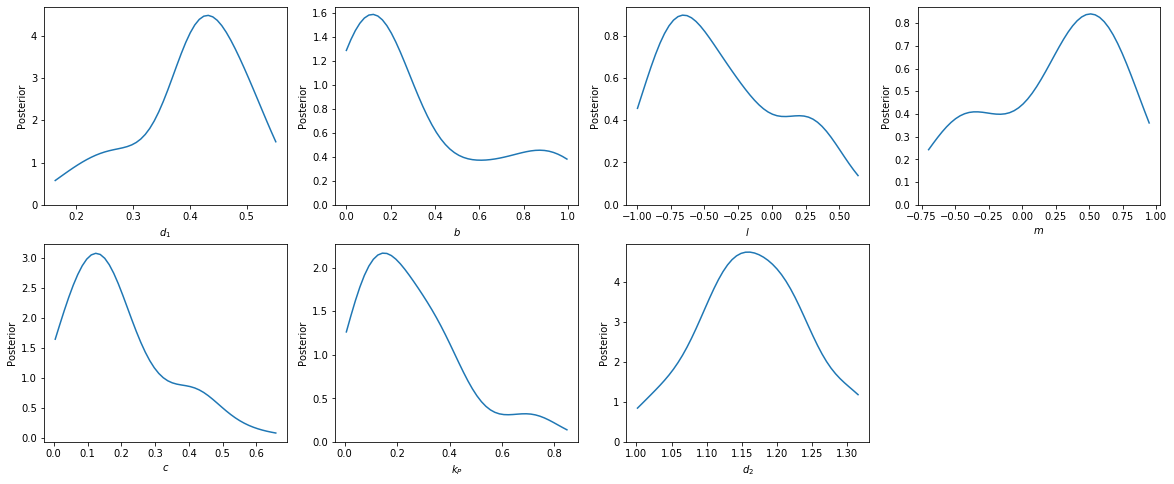

In [9]:
import math
conversion={'at':r'$d_1$','rt':r'$d_2$',
            'ba':r'$b$','bl':r'$l$','bm':r'$m$',
            'ps':r'$k_P$','pi':r'$c$'}
df, w = history.get_distribution(m=0)
result={}
n_paras = len(df.columns)
fig = plt.figure(figsize=[20,8]) 
for index in range(n_paras):
    i = df.columns[index]
    weighted_ave = np.average(df[i],weights=w)
    weighted_var = np.average((np.array(df[i])-weighted_ave)**2,weights=w)
    result[i]=(weighted_ave, weighted_var**0.5)
    ax = fig.add_subplot(math.ceil(n_paras/4),4,index+1)
    pyabc.visualization.plot_kde_1d_highlevel(history, x=i, ax=ax)
    ax.set_xlabel(conversion[i])
print(result)
plt.savefig('estimation pictures/'+'SMM-ABC estimation')
plt.show()